In [2]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("/content/Reviews.csv")

# Display first 5 rows
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


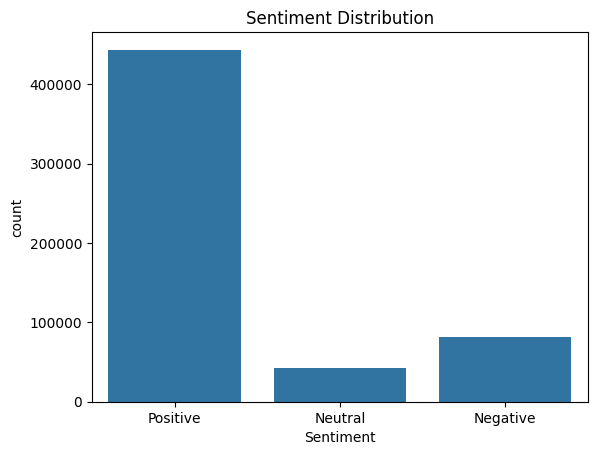

                                                     Text Sentiment
152427  These nibs are very bitter, but I knew they wo...  Positive
405892  I am addicted to these gummy bears. They are s...  Positive
411066  i made a double pot of this our first chilly e...  Negative
49853   not much flavor but at least it doesn't taste ...   Neutral
36291   My dog's vet has been trying to sell me dental...  Positive


In [3]:
# Step 2: Map scores to sentiment labels
def map_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df['Sentiment'] = df['Score'].apply(map_sentiment)

# Check distribution
sns.countplot(x='Sentiment', data=df, order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution")
plt.show()

# Print sample reviews
print(df[['Text', 'Sentiment']].sample(5))

In [4]:
# Map 1–2 -> Negative, 3 -> Neutral, 4–5 -> Positive
def map_sentiment(score):
    if score <= 2: return "Negative"
    if score == 3: return "Neutral"
    return "Positive"

df["Sentiment"] = df["Score"].apply(map_sentiment)

# Peek at distribution
print(df["Sentiment"].value_counts())

Sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64


In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemm = WordNetLemmatizer()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", s)  # links/handles/hashtags
    s = re.sub(r"[^a-z\s']", " ", s)                 # keep letters/apostrophes
    tokens = [w for w in s.split() if w not in stop_words and len(w) > 2]
    lemmed = [lemm.lemmatize(w) for w in tokens]
    return " ".join(lemmed)

# Apply (this can take a minute on full dataset)
df["TextClean"] = df["Text"].apply(clean_text)

# Drop empties just in case
df = df[df["TextClean"].str.strip().astype(bool)]
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,TextClean
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,product arrived labeled jumbo salted peanut pe...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,confection around century light pillowy citrus...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,great taffy great price wide assortment yummy ...


## Preprocessing steps:

**Lowercase** **text** – Normalize for case sensitivity.

**Remove** **punctuation** **& numbers** – Keep only alphabetic content.

**Tokenization** – Break sentences into words.

**Stopword** **removal** – Remove uninformative words (e.g., "and", "the").

**Lemmatization** – Convert words to base form (e.g., "running" → "run").

**Class** **balancing** – Use RandomUnderSampler so the model sees equal representation from all classes.

In [8]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Initialize lemmatizer & stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text cleaning function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/numbers
    tokens = nltk.word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['CleanText'] = df['Text'].astype(str).apply(preprocess_text)

# Handle class imbalance — undersampling the majority class
min_class_size = df['Sentiment'].value_counts().min()

balanced_df = pd.concat([
    resample(df[df['Sentiment'] == 'Positive'],
             replace=False, n_samples=min_class_size, random_state=42),
    resample(df[df['Sentiment'] == 'Negative'],
             replace=False, n_samples=min_class_size, random_state=42),
    resample(df[df['Sentiment'] == 'Neutral'],
             replace=False, n_samples=min_class_size, random_state=42)
])

# Shuffle dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced class counts:")
print(balanced_df['Sentiment'].value_counts())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Balanced class counts:
Sentiment
Negative    42640
Positive    42640
Neutral     42640
Name: count, dtype: int64


In [9]:
## Train/test split + TF-IDF features
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(
    df["TextClean"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"]
)

tfidf = TfidfVectorizer(
    ngram_range=(1,2),       # unigrams + bigrams
    max_features=40000,      # cap features to keep it snappy
    min_df=3                 # ignore super-rare tokens
)

Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

print("Shapes:", Xtr.shape, Xte.shape)

Shapes: (454756, 40000) (113690, 40000)


In [10]:
# Train two baseline models (LogReg, Naive Bayes)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression with class weights (handles imbalance)
lr = LogisticRegression(
    max_iter=2000, n_jobs=-1, multi_class="ovr",
    class_weight="balanced"      # <-- key for full, imbalanced data
)
lr.fit(Xtr, y_train)
pred_lr = lr.predict(Xte)

# Multinomial Naive Bayes (no class weights, but often strong baseline)
nb = MultinomialNB()
nb.fit(Xtr, y_train)
pred_nb = nb.predict(Xte)

print("\n=== Logistic Regression (TF-IDF, class_weight=balanced) ===")
print("Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

print("\n=== Multinomial Naive Bayes (TF-IDF) ===")
print("Accuracy:", accuracy_score(y_test, pred_nb))
print(classification_report(y_test, pred_nb))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression (TF-IDF, class_weight=balanced) ===
Accuracy: 0.8503210484651245
              precision    recall  f1-score   support

    Negative       0.69      0.82      0.75     16408
     Neutral       0.38      0.62      0.47      8528
    Positive       0.97      0.88      0.92     88754

    accuracy                           0.85    113690
   macro avg       0.68      0.77      0.71    113690
weighted avg       0.89      0.85      0.86    113690


=== Multinomial Naive Bayes (TF-IDF) ===
Accuracy: 0.84896648781775
              precision    recall  f1-score   support

    Negative       0.82      0.50      0.62     16408
     Neutral       0.69      0.07      0.13      8528
    Positive       0.85      0.99      0.92     88754

    accuracy                           0.85    113690
   macro avg       0.79      0.52      0.56    113690
weighted avg       0.84      0.85      0.81    113690



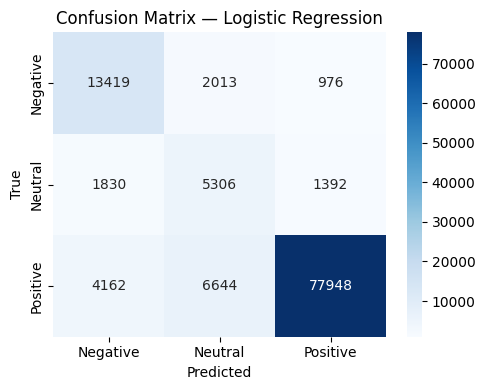

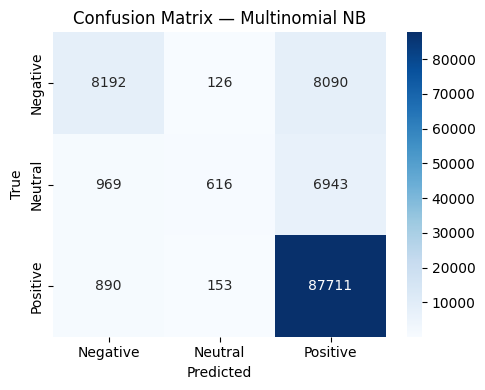

In [11]:
# Confusion matrices
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["Negative","Neutral","Positive"]

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

plot_cm(y_test, pred_lr, "Confusion Matrix — Logistic Regression")
plot_cm(y_test, pred_nb, "Confusion Matrix — Multinomial NB")

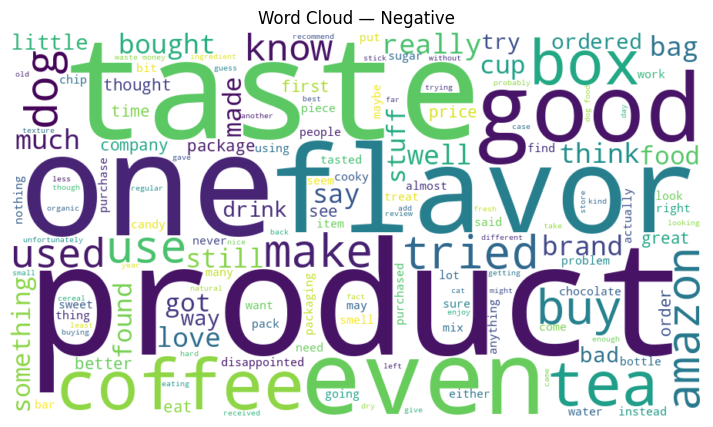

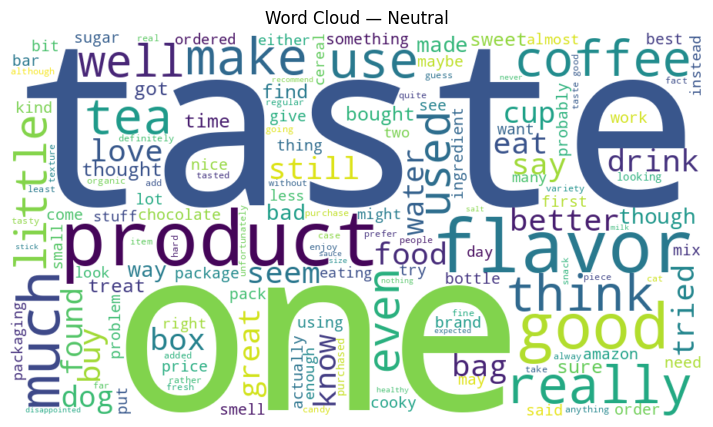

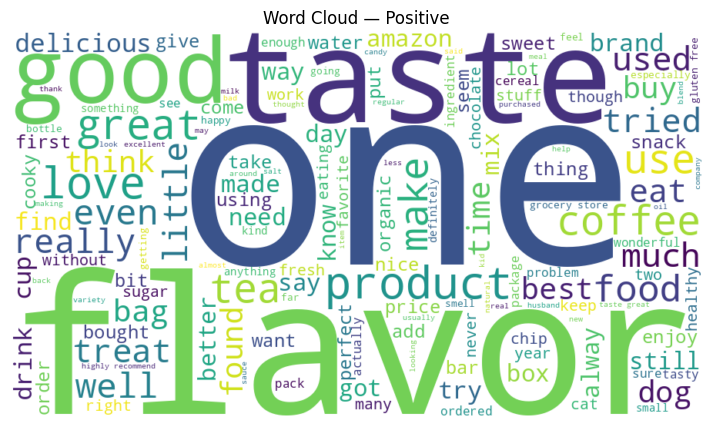

In [12]:
# WORD CLOUD
from wordcloud import WordCloud

for sentiment in ["Negative","Neutral","Positive"]:
    text_blob = " ".join(df.loc[df["Sentiment"]==sentiment, "TextClean"].sample(min(20000, sum(df["Sentiment"]==sentiment),)))
    wc = WordCloud(width=900, height=500, max_words=150, background_color="white").generate(text_blob)
    plt.figure(figsize=(9,5))
    plt.imshow(wc, interpolation="bilinear"); plt.axis("off")
    plt.title(f"Word Cloud — {sentiment}")
    plt.show()

In [13]:
#Top features (most “positive”/“negative” words) from Logistic Regression
import numpy as np
feat_names = np.array(tfidf.get_feature_names_out())

# For OVR, coef_ rows correspond to classes in lr.classes_
for i, cls in enumerate(lr.classes_):
    coefs = lr.coef_[i]
    top_pos_idx = np.argsort(coefs)[-20:]
    top_neg_idx = np.argsort(coefs)[:20]

    print(f"\nTop + words for class '{cls}':")
    print(", ".join(feat_names[top_pos_idx]))

    print(f"Top - words for class '{cls}':")
    print(", ".join(feat_names[top_neg_idx]))


Top + words for class 'Negative':
might good, threw, return, bland, weak, stale, yuck, great review, never buy, tasteless, disgusting, unfortunately, horrible, disappointment, disappointed, awful, disappointing, two star, terrible, worst
Top - words for class 'Negative':
great, delicious, perfect, best, love, highly recommend, excellent, hooked, wonderful, favorite, good, amazing, nice, awesome, skeptical, well worth, yummy, even better, downside, addicted

Top + words for class 'Neutral':
anything special, least favorite, guess, bag arrived, great either, hoping, mediocre, tea purchased, plus side, average, think buy, little disappointed, bad great, decent, nothing special, get wrong, unfortunately, however, okay, three star
Top - words for class 'Neutral':
perfect, one star, four star, delicious, hooked, yum, well worth, excellent, highly recommended, wonderful, highly, love, skeptical, star instead, highly recommend, great, ever, can wait, definitely recommend, better expected

Top

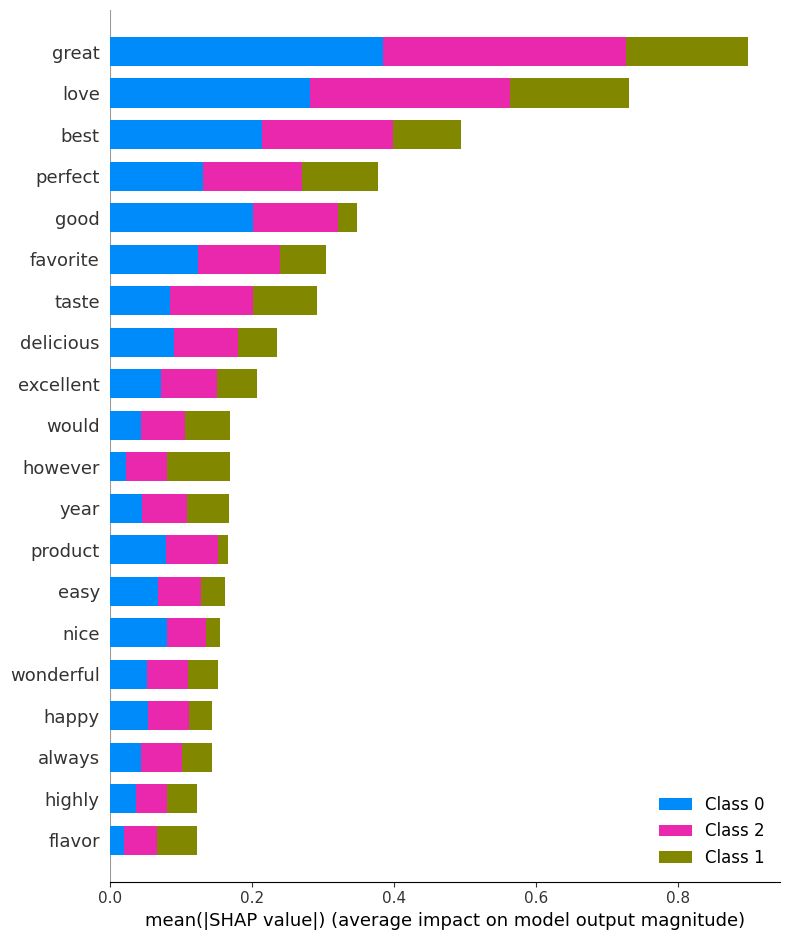

In [15]:
# ===== SHAP: Bar plot only (TF-IDF + Logistic Regression) =====
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have:
#   tfidf (fitted TfidfVectorizer)
#   lr    (fitted LogisticRegression)
#   Xtr   (train TF-IDF matrix)
#   Xte   (test TF-IDF matrix)
#   y_test

# 1) Sample the test set to keep it fast/light
sample_n = min(2000, Xte.shape[0])
rng = np.random.default_rng(42)
idx = rng.choice(Xte.shape[0], size=sample_n, replace=False)
Xte_sample = Xte[idx]

# 2) Build LinearExplainer for a linear model on sparse TF-IDF
explainer = shap.LinearExplainer(lr, Xtr)

# 3) Compute SHAP values for the sample
# For multiclass LR, shap_values is an array [n_samples, n_features, n_classes]
shap_values = explainer.shap_values(Xte_sample)

# 4) Feature names from TF-IDF
feat_names = tfidf.get_feature_names_out()

# 5) Plot **bar** summary (mean |SHAP|). Convert sparse -> dense ONLY for plotting.
Xdense = Xte_sample.toarray()
shap.summary_plot(
    shap_values,
    Xdense,
    feature_names=feat_names,
    plot_type="bar",   # <-- bar plot only
    show=True
)

# Optional: save the figure
# plt.gcf().savefig("shap_bar_text.png", dpi=200, bbox_inches="tight")


In [17]:
# ==== Predict Sentiment for New Reviews (with confidence) ====

# 1) Provide some new reviews (edit these)
new_reviews = [
    "The product quality is amazing! Will definitely buy again.",
    "Worst purchase ever. Completely useless and a waste of money.",
    "It's okay, delivery was on time but packaging could be better."
]

# 2) If you defined preprocess_text earlier, use it; otherwise pass-through
def maybe_preprocess(x):
    try:
        return preprocess_text(x)  # heavy NLTK version (if you ran it)
    except NameError:
        return x                    # you trained on raw text with TF-IDF stopwords

new_reviews_clean = [maybe_preprocess(r) for r in new_reviews]

# 3) Vectorize using the fitted TF-IDF, then predict with your trained model (lr)
X_new = tfidf.transform(new_reviews_clean)
pred_labels = lr.predict(X_new)
pred_proba = lr.predict_proba(X_new)  # columns correspond to lr.classes_

# 4) Pretty print results
classes = lr.classes_  # e.g., ['Negative','Neutral','Positive']
for review, label, probs in zip(new_reviews, pred_labels, pred_proba):
    # confidence = probability of the predicted class
    conf = probs[list(classes).index(label)]
    print("─" * 80)
    print("Review:", review)
    print(f"Predicted: {label} (confidence: {conf:.3f})")
    # Show all class probabilities (nice for debugging/portfolio)
    print("Probabilities:", {c: f"{p:.3f}" for c, p in zip(classes, probs)})

────────────────────────────────────────────────────────────────────────────────
Review: The product quality is amazing! Will definitely buy again.
Predicted: Positive (confidence: 0.974)
Probabilities: {'Negative': '0.006', 'Neutral': '0.020', 'Positive': '0.974'}
────────────────────────────────────────────────────────────────────────────────
Review: Worst purchase ever. Completely useless and a waste of money.
Predicted: Negative (confidence: 0.999)
Probabilities: {'Negative': '0.999', 'Neutral': '0.001', 'Positive': '0.000'}
────────────────────────────────────────────────────────────────────────────────
Review: It's okay, delivery was on time but packaging could be better.
Predicted: Neutral (confidence: 0.634)
Probabilities: {'Negative': '0.341', 'Neutral': '0.634', 'Positive': '0.025'}
